In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

<h1>Walsh function decomposition:</h1>

In [24]:
def bitrev_perm(a,bits):
    b = np.zeros_like(a)
    for i in range(2**bits):
        j = int(bin(i)[2:].zfill(bits)[::-1],base=2)
        b[j] = a[i]
    return b

def gray(x):
    return x^(x>>1)

def cut_msb(x):
    return int('0'+np.binary_repr(x)[1:],base=2)

def fwht(b,bits):
    """Fast Walsh–Hadamard Transform of array b."""
    a = np.copy(b)
    h = 1
    while h < len(a):
        for i in range(0, len(a), h * 2):
            for j in range(i, i + h):
                x = a[j]
                y = a[j + h]
                a[j] = (x + y)/2
                a[j + h] = (x - y)/2
        h *= 2
    #Return coefficients
    return bitrev_perm(a,bits)

def get_interp(amp_list):
    return interp1d(np.linspace(0,1,num=amp_list.shape[0],endpoint=False),amp_list)

In [22]:
test_array = np.abs(np.random.normal(0, 1, 2**3))
test_array /= np.linalg.norm(test_array)
print(test_array)
print(fwht(test_array,3))

[0.48449307 0.1448173  0.39467439 0.53824369 0.32563816 0.36949112
 0.02922571 0.23537677]
[ 0.31524503  0.07531209  0.01586489 -0.09176681 -0.0067372   0.05576381
  0.0806929   0.04011837]


<h1>Walsh state preparation:</h1>

In [220]:
def walsh_operator(wires,ancilla,coeff,eps0):
    for q in wires[:-1]:
        qml.Toffoli([ancilla[0],q,wires[-1]])
    
    for q in reversed(wires[:-1]):
        qml.Toffoli([ancilla[0],q,wires[-1]])

def get_wires(order,wires):
    bin_ord = list(np.binary_repr(order,width=len(wires)))
    bin_ord.reverse()
    bin_ord = np.array(bin_ord)
    indices = np.where(bin_ord == '1')
    return np.take_along_axis(np.array(wires),indices[0],0)

def walsh_unitary(f,wires,ancilla,eps0,k):
    coeffs = fwht(f,k)
    grayperm = gray(np.array(range(2**k)))
    for i in range(1,2**k-1):
        if i==1:
            qml.CRZ(-2*coeffs[grayperm[1]]*eps0,wires=[ancilla[0],get_wires(grayperm[1],wires)[-1]])
        on_wires = get_wires(grayperm[i+1],wires)
        qml.Toffoli([ancilla[0],wires[len(np.binary_repr(cut_msb(grayperm[i])^cut_msb(grayperm[i+1])))-1],on_wires[-1]])
        qml.CRZ(-2*coeffs[grayperm[i+1]]*eps0,wires=[ancilla[0],on_wires[-1]])
    return coeffs[0]

def walsh_state_prep(wires,ancilla,f,eps0,k):
    qml.Hadamard(ancilla[0])
    for wire in wires:
        qml.Hadamard(wire)
    zero_coeff = walsh_unitary(f,wires,ancilla,eps0,k)
    if np.abs(zero_coeff) > 1e-6:
        qml.RZ(1*zero_coeff*eps0,wires=ancilla[0])
    qml.Hadamard(ancilla[0])
    qml.adjoint(qml.S)(ancilla[0])

In [377]:
num_qubits = 2
amp_list = np.abs(np.random.normal(0,1,2**num_qubits))
amp_list = amp_list/np.linalg.norm(amp_list)

In [378]:
dev = qml.device('default.qubit',wires=num_qubits+1)

@qml.qnode(dev)
def circuit(wires,ancilla,f,eps0,num_qubits):
    walsh_state_prep(wires,ancilla,f,eps0,num_qubits)
    return qml.state()

@qml.qnode(dev)
def mottonen_circuit(f):
    qml.MottonenStatePreparation(state_vector=f, wires=range(num_qubits))
    return qml.state()

In [379]:
print(qml.specs(circuit)(np.array(range(1,num_qubits+1)),np.array([0]),amp_list,1,num_qubits))
print(qml.specs(mottonen_circuit,expansion_strategy='device')(amp_list))

{'resources': Resources(num_wires=3, num_gates=11, gate_types=defaultdict(<class 'int'>, {'Hadamard': 4, 'CRZ': 3, 'Toffoli': 2, 'RZ': 1, 'Adjoint(S)': 1}), gate_sizes=defaultdict(<class 'int'>, {1: 6, 2: 3, 3: 2}), depth=9, shots=Shots(total_shots=None, shot_vector=())), 'num_observables': 1, 'num_diagonalizing_gates': 0, 'num_trainable_params': 0, 'num_device_wires': 3, 'device_name': 'default.qubit', 'expansion_strategy': 'gradient', 'gradient_options': {}, 'interface': 'auto', 'diff_method': 'best', 'gradient_fn': 'backprop'}
{'resources': Resources(num_wires=3, num_gates=5, gate_types=defaultdict(<class 'int'>, {'RY': 3, 'CNOT': 2}), gate_sizes=defaultdict(<class 'int'>, {1: 3, 2: 2}), depth=4, shots=Shots(total_shots=None, shot_vector=())), 'num_observables': 1, 'num_diagonalizing_gates': 0, 'num_trainable_params': 3, 'num_device_wires': 3, 'device_name': 'default.qubit', 'expansion_strategy': 'gradient', 'gradient_options': {}, 'interface': 'auto', 'diff_method': 'best', 'gradie

In [380]:
from qiskit import QuantumCircuit
mottonen_circuit.construct([amp_list],{})
t = circuit.qtape.to_openqasm()
t_m = mottonen_circuit.qtape.to_openqasm()
qc = QuantumCircuit.from_qasm_str(t)
qc_m =QuantumCircuit.from_qasm_str(t_m)

In [381]:
from collections import Counter
def inspect_circuit(qc):
    gate_map = Counter()
    for gate in qc.data:
        if gate[0].name not in ['measure','barrier']:
            gate_map[gate[0].name] += 1
    print(gate_map)
    print(qc.depth())

In [382]:
inspect_circuit(qc)
inspect_circuit(qc_m)

Counter({'h': 4, 'crz': 3, 'ccx': 2, 'rz': 1, 'sdg': 1})
10
Counter({'ry': 3, 'cx': 2})
5


In [383]:
from qiskit import QuantumCircuit, transpile
backend = provider.get_backend('ibm_osaka')

In [384]:
qc_t = transpile(qc,basis_gates=['rz','sx','x','cx'])
qc_t_m = transpile(qc_m,basis_gates=['rz','sx','x','cx'])
inspect_circuit(qc_t)
inspect_circuit(qc_t_m)
# qc_t.draw()

Counter({'rz': 26, 'cx': 18, 'sx': 6})
38
Counter({'rz': 6, 'sx': 6, 'cx': 2})
11


In [385]:
qc_t = transpile(qc,backend=backend,optimization_level=3)
qc_t_m = transpile(qc_m,backend=backend,optimization_level=3)
inspect_circuit(qc_t)
inspect_circuit(qc_t_m)

Counter({'rz': 94, 'sx': 61, 'ecr': 24, 'x': 4})
131
Counter({'rz': 11, 'sx': 7, 'ecr': 2})
17


In [343]:
plt.rcParams['text.usetex']=True

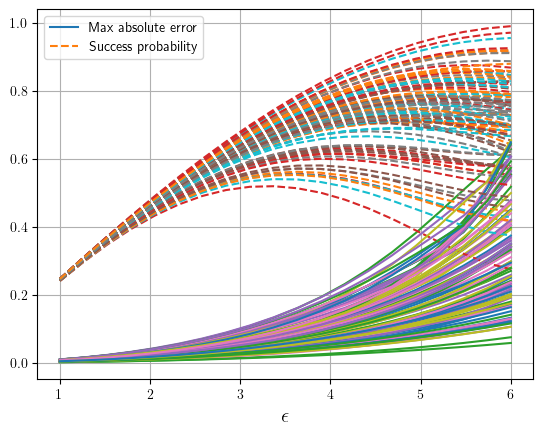

In [344]:
for i in range(100):
    amp_list = np.abs(np.random.normal(0,1,2**num_qubits))
    amp_list = amp_list/np.linalg.norm(amp_list)
    max_error = []
    prob = []
    samples = np.linspace(1,6,num=20)
    sample_points = np.linspace(0,1,num=2**num_qubits,endpoint=False)
    for e in samples:
        res = circuit(np.array(range(1,num_qubits+1)),np.array([0]),amp_list,e,num_qubits)
        res_p = res[res.shape[0]//2:]
        prob.append(np.linalg.norm(res_p))
        res_pn = np.abs(res_p)/np.linalg.norm(res_p)
        max_error.append(np.max(np.abs(res_pn-amp_list)))
    if i==0:
        plt.plot(samples,max_error,label='Max absolute error')
        plt.plot(samples,prob,linestyle='--',label='Success probability')      
    plt.plot(samples,max_error)
    plt.plot(samples,prob,linestyle='--')
plt.xlabel(r'$\epsilon$',fontsize=15)
plt.legend()
plt.grid()
plt.show()

In [345]:
res = circuit(np.array(range(1,num_qubits+1)),np.array([0]),amp_list,2,num_qubits)

0.4705804612267997
[0.68987608 0.46552114 0.18657658 0.52206345]


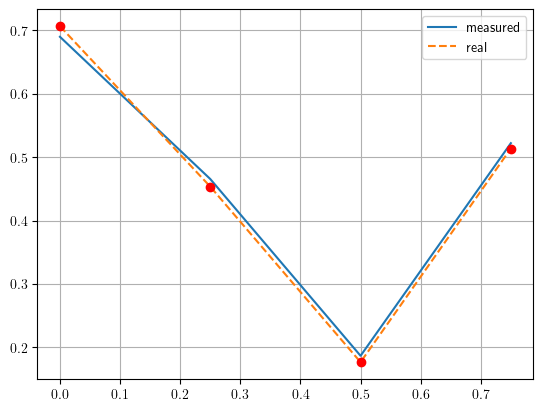

In [346]:
res_p = res[res.shape[0]//2:]
print(np.linalg.norm(res_p))
res_pn = np.abs(res_p)/np.linalg.norm(res_p)
sample_points = np.linspace(0,1,num=2**num_qubits,endpoint=False)
print(res_pn)
plt.plot(sample_points,res_pn,label='measured')
plt.plot(sample_points,get_interp(amp_list)(sample_points),label='real',linestyle='--')
plt.scatter(sample_points,amp_list,c='red',zorder=2)
plt.legend()
plt.grid()
plt.show()

In [166]:
amp_list = np.array([0.12787755, 0.02232474, 0.29006564, 0.26871596, 0.65356168, 0.53247637,
 0.33595946, 0.05709531])

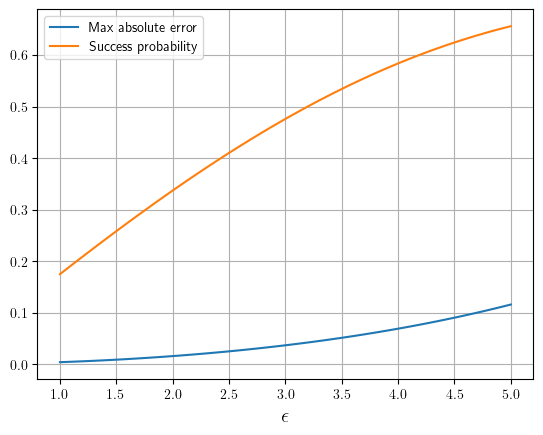

In [170]:
max_error = []
prob = []
samples = np.linspace(1,5,num=100)
sample_points = np.linspace(0,1,num=2**num_qubits,endpoint=False)
for e in samples:
    res = circuit(np.array(range(1,num_qubits+1)),np.array([0]),amp_list,e,num_qubits)
    res_p = res[res.shape[0]//2:]
    prob.append(np.linalg.norm(res_p))
    res_pn = np.abs(res_p)/np.linalg.norm(res_p)
    max_error.append(np.max(np.abs(res_pn-amp_list)))
plt.plot(samples,max_error,label='Max absolute error')
plt.plot(samples,prob,label='Success probability')
plt.xlabel(r'$\epsilon$',fontsize=15)
plt.legend()
plt.grid()
plt.show()

<h1>Running circuits on IBMQ:</h1>

In [161]:
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService
import pennylane_qiskit as qmlqiskit

In [162]:
provider = IBMProvider()
service = QiskitRuntimeService()

In [163]:
amp_list = np.abs(np.random.normal(0,1,2**num_qubits))
amp_list = amp_list/np.linalg.norm(amp_list)
print(amp_list)

[0.10442091 0.2972729  0.58050814 0.47237221 0.00768139 0.34246133
 0.44876996 0.14787379]


In [171]:
amp_list = np.array([0.12787755, 0.02232474, 0.29006564, 0.26871596, 0.65356168, 0.53247637,
 0.33595946, 0.05709531])

In [172]:
num_qubits = 3
shots = 4096
real_device = qmlqiskit.IBMQDevice(wires=num_qubits+1,provider=provider,backend='ibm_osaka',shots=shots)

In [174]:
@qml.qnode(real_device)
def real_circuit(wires,ancilla,f,eps0,k):
    walsh_state_prep(wires,ancilla,f,eps0,k)
    return qml.counts()

In [ ]:
real_circuit(np.array(range(1,num_qubits+1)),np.array([0]),amp_list,5,num_qubits)

In [187]:
job = service.jobs(backend_name='ibm_osaka')[0]
res = job.result()

In [188]:
sum = 0
for key,val in res.get_counts().items():
    if key[-1]=='1':
        sum+=val
print('Measured success probability is',sum/shots)

Measured success probability is 0.54052734375


In [189]:
output = np.zeros(2**num_qubits)
for key,val in res.get_counts().items():
    if key[-1]=='1':
        output[int(''.join(reversed(key[:-1])),2)]+=val
output/=sum

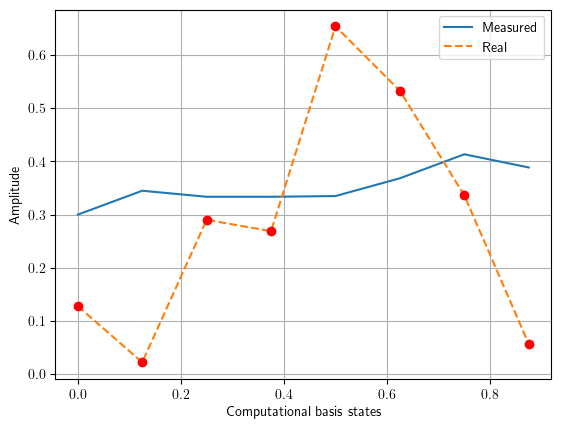

In [190]:
sample_points = np.linspace(0,1,num=2**num_qubits,endpoint=False)
plt.plot(sample_points,np.sqrt(output),label='Measured')
plt.plot(sample_points,get_interp(amp_list)(sample_points),label='Real',linestyle='--')
plt.scatter(sample_points,amp_list,c='red',zorder=2)
plt.ylabel('Amplitude')
plt.xlabel('Computational basis states')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# max_error = []
# prob = []
# samples = np.linspace(1,10,num=10)
# sample_points = np.linspace(0,1,num=2**num_qubits,endpoint=False)
# for e in samples:
#     res2 = real_circuit(np.array(range(1,num_qubits+1)),np.array([0]),get_interp(amp_list),e,num_qubits)
#     sum2 = 0
#     for key,val in res2.items():
#         if key[0]=='1':
#             sum2+=val
#     output2 = np.zeros(2**num_qubits)
#     for key,val in res2.items():
#         if key[0]=='1':
#             output2[int(''.join(key[1:]),2)]+=val
#     output2/=sum2
#     prob.append(sum2/shots)
#     max_error.append(np.max(np.abs(np.sqrt(output2)-get_interp(amp_list)(sample_points))))
# plt.plot(samples,max_error,label='Max absolute error')
# plt.plot(samples,prob,label='Success probability')
# plt.xlabel(r'$\epsilon$',fontsize=15)
# plt.legend()
# plt.grid()
# plt.show()

In [430]:
print(amp_list)

[0.12787755 0.02232474 0.29006564 0.26871596 0.65356168 0.53247637
 0.33595946 0.05709531]


In [12]:
real_job = service.jobs(backend_name='ibm_osaka')[0]

In [17]:
real_qc = real_job.inputs['circuits'][0]

In [23]:
dir(real_qc)

['__and__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iand__',
 '__init__',
 '__init_subclass__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '__xor__',
 '_ancillas',
 '_append',
 '_base_name',
 '_calibrations',
 '_check_dups',
 '_clbit_indices',
 '_clbits',
 '_control_flow_scopes',
 '_create_creg',
 '_create_qreg',
 '_data',
 '_global_phase',
 '_increment_instances',
 '_layout',
 '_metadata',
 '_name_update',
 '_op_start_times',
 '_parameter_table',
 '_parameters',
 '_peek_previous_instruction_in_scope',
 '_pop_previous_instruction_in_scope',
 '_pop_scope',
 '_push_scope',
 '_qubit_indices',
 '_qubits',
 '_resolve_classical_resource',
 '_unroll_param_dict',
 '_unsorted_paramete